<a href="https://colab.research.google.com/github/MatheusOrange211/Serie-temporal-covid-19/blob/main/Serie_Temporal_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import zipfile
import requests
from io import BytesIO
import datetime
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

#Funções

Os dados estão originalmente salvos no github em extensão `.zip `. Isso porque o arquivo possui mais de 50MB de tamanho. Pensando em facilitar a vida de quem for analisar este projeto, e com a ajuda do [stackOverflow](https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url) (obviamente), criei uma função que realiza uma requisição da URL onde está o meu arquivo, dando um `get`(pegando) os meus dados de lá. Depois com zipfile, eu tento extrair o arquivo, no entanto, por estar pegando de uma for diferente do convencional, meus dados estão comportados de uma forma diferente. Usando  `BytesIo`, eu evito o seguinte erro de entendimento:

```
'bytes' object has no attribute 'seek'
```
Por fim, extraio o arquivo e o retorno. Entretanto, o mesmo não aparece de primeira no seu colab, a não ser que você atualize. Clique no botão com a pastinha e um simbolo de reload. o arquivo agora está lá. Pronto para uso.

In [3]:
def unzip_url_file(url):
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(BytesIO(r.content))
  file = z.extractall()
  return file

Formatando os dados do dataframe Brasil e retornando ele ordenado por data ( do mais antigo até o mais atual ).

In [4]:
def formated_df_brasil(dataset: pd.DataFrame):
  dataset = dataset.drop(columns=["estado","municipio","coduf"],axis=1) #estamos falando do ambito nacional \(°_°)/
  dataset["data"] = pd.to_datetime(dataset['data'],format="%d/%m/%Y")
  dataset["regiao"] = dataset["regiao"].astype(str)
  dataset["populacaoTCU2019"] = dataset["populacaoTCU2019"].astype(int)
  dataset = dataset.sort_values(by="data")
  dataset.reset_index(drop=True,inplace=True)
  return dataset

plotar lineplots simples

In [5]:
def plot_br(data,yaxis, title:str = ""):
  plt.figure(figsize=(15,5))
  ax = sns.lineplot(data=data,x=data.index,y=yaxis)
  plt.title(title)
  return ax;

plotar dois gráficos juntos de forma simples

In [6]:
def plot_graficos_simples(data1, yaxis1,yaxis2,title:str="",lista_legend:list = []):
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data1,x=data1.index,y=yaxis1)
  sns.lineplot(data=data1,x=data1.index,y=yaxis2)
  plt.title(title)
  plt.legend(lista_legend)
  return plt.show()

plotar gráficos de casos/ óbitos, média móvel e tendência

In [7]:
def plot_media_trend(data1,data2,yaxis1,yaxis2,yaxis3,title:str="",lista_legend:list = []):
  
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data1,x=data1.index,y=yaxis1)
  sns.lineplot(data=data1,x=data1.index,y=yaxis2)
  sns.lineplot(data=data2,x=data2.index,y=yaxis3)

  plt.title(title)
  plt.legend(lista_legend)
  return plt.show()

Plotando o detrend* para saber como nosso dados se comportando sendo aditivos ou multiplicativos

In [8]:
def detrend(data, option):
  data.observed.plot(color='r',linewidth=2) #não faz diferença se for multiplicativo ou multiplicativo, 
                                                        #queremos apenas os dados originais
  if str.lower(option) == 'mult':
    (data.observed / data.seasonal).plot(figsize=(20,5),color='b')
    plt.legend(['Casos Covid','Detrend Multiplicativo ( dados covid / sazonalidade) '])
    plt.title("Casos de Covid e Detrend Multiplicativo")
    return plt.show()
  elif str.lower(option) == 'add':
    (decomposicao_add.observed - decomposicao_add.trend).plot(figsize=(20,5),color='g')
    plt.legend(['Casos Covid','Detrend Aditivo ( dados covid - sazonalidade) '])
    plt.title("Casos de Covid e Detrend Aditivo")
    return plt.show()
  else:
    return "Você passou algo errado ai :("
  


Função para treinar modelo ARIMA. Passo o dataframe de casos treino a ordem dos valores pdq e o periodo que quero prever.

In [9]:
def arima_model(casos_treino: pd.DataFrame,ordem: tuple =(1,1,1),periodo : int = 31):
  
  modelo_casos_arima = ARIMA(casos_treino.values,order = ordem)
  modelo_casos_treinado_arima = modelo_casos_arima.fit()
  return modelo_casos_treinado_arima.forecast(steps=periodo)[0]


Função para treinar modelo SARIMA. Passando a coluna desejada de treino, a ordem p,d,q, a ordem sazonal (P,D,Q,M) e o período de tempo que queremos prever.

In [10]:
def model_sarima(casos_treino: pd.DataFrame, ordem:tuple=(1,1,1),
                 ordem_sazonal:tuple =(0,0,0,0), periodo:int =31):

  modelo_casos_sarima = SARIMAX(casos_treino.values,
                                order= ordem,
                                seasonal_order= ordem_sazonal)
  modelos_casos_sarima_treinado = modelo_casos_sarima.fit()
  return modelos_casos_sarima_treinado.forecast(steps= periodo )

Função de métrica do erro quadrado médio

In [11]:
def erro_quadrado_medio(dataset_teste, dataset_previsão, modelo: str, squarede: bool =False):
    mse_test = mean_squared_error(dataset_teste, dataset_previsão, squared=squarede)
    return f"RESULTADOS {str.upper(modelo)} = {mse_test}"

#Importando Dados

In [12]:
url = "https://github.com/MatheusOrange211/Serie-temporal-covid-19/raw/main/dados/dados_covid_mod_1.zip"


In [13]:
 unzip_url_file(url) #arquivo descompactado e já disponível para uso.
 file_covid = "/content/dados_covid_mod_1.csv"

In [14]:
dados = pd.read_csv(file_covid,sep=";",engine='python')
dados

,regiao,estado,municipio,coduf,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,NaN,NaN,76,25/02/2020,9,210147125.0,0,0,0,0
1,Brasil,NaN,NaN,76,26/02/2020,9,210147125.0,1,1,0,0
2,Brasil,NaN,NaN,76,27/02/2020,9,210147125.0,1,0,0,0
3,Brasil,NaN,NaN,76,28/02/2020,9,210147125.0,1,0,0,0
4,Brasil,NaN,NaN,76,29/02/2020,9,210147125.0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1048570,Sudeste,SP,Holambra,35,24/09/2020,39,14930.0,346,9,3,0
1048571,Sudeste,SP,Holambra,35,25/09/2020,39,14930.0,347,1,3,0
1048572,Sudeste,SP,Holambra,35,26/09/2020,39,14930.0,352,5,3,0
1048573,Sudeste,SP,Holambra,35,27/09/2020,40,14930.0,352,0,3,0


In [15]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   regiao            1048575 non-null  object 
 1   estado            1048245 non-null  object 
 2   municipio         1034637 non-null  object 
 3   coduf             1048575 non-null  int64  
 4   data              1048575 non-null  object 
 5   semanaEpi         1048575 non-null  int64  
 6   populacaoTCU2019  1043823 non-null  float64
 7   casosAcumulado    1048575 non-null  int64  
 8   casosNovos        1048575 non-null  int64  
 9   obitosAcumulado   1048575 non-null  int64  
 10  obitosNovos       1048575 non-null  int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 88.0+ MB


Os dados vem diretamente do site do governo federal e vão até a data de 17/01/2021. Pra começar, temos os dados nacionais e dados por estados/Regiões. vou dividir o dataset em dois, analisando de forma mais ampla, vendo todo o País, e olhando depois, por regiões.

In [16]:
dados_brasil = dados.query("regiao == 'Brasil'")
dados_brasil = formated_df_brasil(dados_brasil)
dados_brasil.head()

,regiao,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
0,Brasil,2020-02-25,9,210147125,0,0,0,0
1,Brasil,2020-02-26,9,210147125,1,1,0,0
2,Brasil,2020-02-27,9,210147125,1,0,0,0
3,Brasil,2020-02-28,9,210147125,1,0,0,0
4,Brasil,2020-02-29,9,210147125,2,1,0,0


Criar um dataframe de Série Temporal Para analisar casos novos e óbitos Novos.

In [17]:
br_casos_covid = dados_brasil[["data","casosNovos"]].copy()
br_casos_covid["mes"] = br_casos_covid["data"].dt.month
br_casos_covid["ano"] = br_casos_covid["data"].dt.year
br_casos_covid.set_index('data',inplace=True)

In [18]:
br_casos_covid.head(5)

,casosNovos,mes,ano
data,,,
2020-02-25,0,2,2020
2020-02-26,1,2,2020
2020-02-27,0,2,2020
2020-02-28,0,2,2020
2020-02-29,1,2,2020


#Prevendo Casos Novos - Brasil

temos orignalmente isso

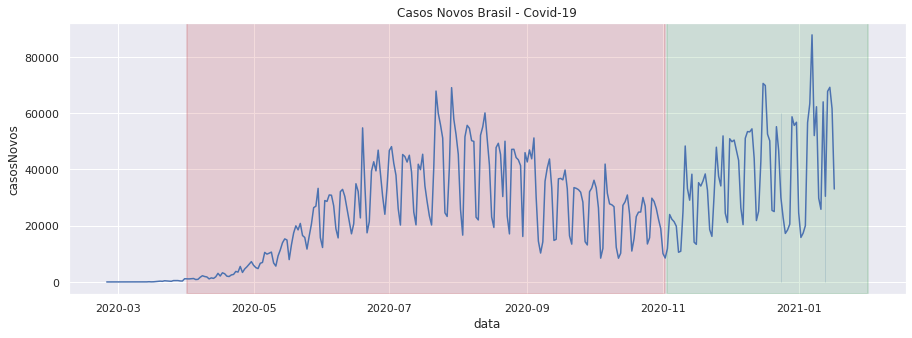

In [19]:
plot_br(br_casos_covid,"casosNovos",'Casos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-04-01'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)

Observando os casos novos ao longo dos meses de 2020, temos várias curvas ao longo do ano, começando em 2020-05 (Maio) uma crescente de casos, chegando ao ápice de mais de 60 mil casos entre Julho e Agosto, tendo uma queda, em uma primeira onda, e depois, a partir de novembro, o crescimento da segunda onda com muito mais força, ultrapassando os mais de 80 novos casos diários no início de janeiro de 2021. 
**Observação**: Em vermelho, temos a primeira onda e em verde a segunda onda se configurando.

Algumas informações interessantes a se analisar, como a média móvel, contudo, assim como vemos em jornais, a média móvel dos últimos 7 dias.

In [20]:
br_casos_covid["media_movel_7_dias"] = br_casos_covid["casosNovos"].rolling(window=7,center=True).mean()

No fim, o que temos é isso:

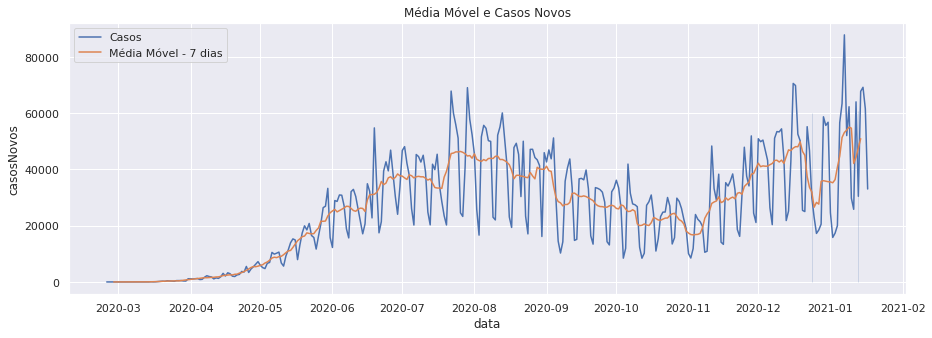

In [21]:
plot_graficos_simples(br_casos_covid,"casosNovos","media_movel_7_dias",
                      "Média Móvel e Casos Novos",["Casos","Média Móvel - 7 dias"])

Olhando então a configuração das médias móveis, então vamos começar a realizar previsões de buscar prever novos casos.

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_br = seasonal_decompose(br_casos_covid["casosNovos"],freq=12,model='additive')

Temos abaixo, a demonstração das tendências de casos novos ao longo do ano de 2020 junto da média móvel e dos casos.

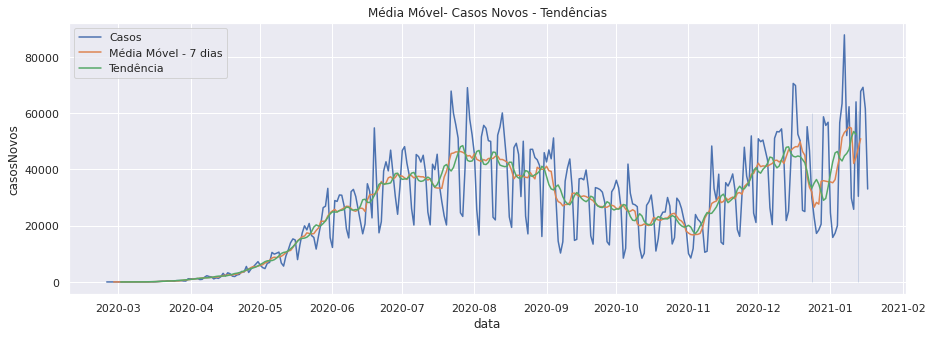

In [23]:
tendencia_casos_novos = decomposicao_br.trend

plot_media_trend(br_casos_covid,tendencia_casos_novos,"casosNovos","media_movel_7_dias",
                      tendencia_casos_novos,"Média Móvel- Casos Novos - Tendências",
                      ["Casos","Média Móvel - 7 dias","Tendência"])

Preparando então nosso dataset para prever novos casos em 2021. A ideia é tentar prever os casos em 2021 para os 3 primeiros meses. Contudo, temos que ter em mente algumas coisas:

* A vacina da Covid-19 está em fase inicial de implementação;
* Os dados da covid são muito recentes, não sendo possível prever por longos períodos, além é claro, do cenário poder mudar dado que tudo isso ainda é novo em nossa sociedade;

Vamos tentar prever o mês de Dezembro e se funcionar, tentaremos prever janeiro a março, se possível. Contudo, temos um grande problema para resolver antes de mais nada, **Qual modelo de forecast (previsão) utilizar? e por quê?**

#**Previsões Casos**

## <font size='12px'> **Observações Iniciais**</font>

Uma das primeiras coisas que se percebe quando trabalhamos com séries temporais é a quantidade de modelos de previsão e suas respectivas capacidades em prever um determinado conjunto de dados, com base em algumas específicadades.<br>
Quando você começa a trabalhar com coisas assim, requer um tempo de leitura para poder identificar características que possam te auxiliar a compreender o "melhor" modelo para prever seus dados. Vamos ver então o que já temos sabemos no momento:

* DataFrame composto por datas (indice) e colunas de casos e óbitos;
* Os dados de **casos e óbitos** são do tipo **QUANTITATIVO - DISCRETO**;

<font size='8px'>**Algumas questões a se analisar**</font><br>
A covid-19 possui em torno de um ano de existência (em relação a pandemia). Como trabalhar com a questão da *sazonalidade*? Afinal, por sazonalidade, entendemos ser uma repetição que ocorre sempre em determinados períodos de tempo, como explicado no site da [Portal Action](http://www.portalaction.com.br/series-temporais/23-sazonalidade#:~:text=Dizemos%20que%20uma%20s%C3%A9rie%20temporal,m%C3%AAs%20em%20todos%20os%20anos.):
>"Dizemos que uma série temporal é sazonal quando os fenômenos que ocorrem durante o tempo se repete a cada período idêntico de tempo, ou seja, fenômenos que ocorrem diariamente em uma certa hora, todos os dias, ou em um certo mês em todos os anos. Um exemplo fácil de visualizar seria o aumento das vendas de passagens aéreas todos os finais de ano, ou ainda, o aumento das vendas do comércio no período do natal."

Entretanto, a covid-19 ainda é uma doença desconhecida. Muitas informações relacionadas a ela ainda serão confirmadas com o passar do tempo, mas apenas nos resta paciência para aguardar um melhor entendimento quanto a sua sazonalidade.Como aponta a matéria publicada no [UOL](https://www.uol.com.br/vivabem/noticias/bbc/2020/09/15/covid-19-do-futuro-devera-ser-sazonal-como-outros-virus-respiratorios-sugerem-pesquisadores.htm), o coronavírus tem chances de se tornar uma doença sazonal assim como a gripe e outras doenças respiratórias que aparecem mais no inverno como aponta em um trecho da matéria:

>Já conhecemos diversos vírus que causam mais problemas em determinadas estações do ano, como o da influenza e o vírus sincicial respiratório (RSV) no inverno ou o da parainfluenza em setembro para o Hemisfério Sul.

Contudo, até lá, é necessário paciência pois é preciso ter uma imunidade coletiva suficiente para que este efeito seja gerado.

>"A covid-19 veio para ficar e ela continuará a causar surtos ao longo do tempo até que a imunidade coletiva seja atingida. Assim, o público precisará aprender a viver com a doença e a continuar praticando as melhores medidas de prevenção, incluindo usar máscaras, evitar aglomerações, distanciamento físico e higiene das mãos", explicou em comunicado à imprensa Hassan Zaraket, líder do estudo e pesquisador da Universidade Americana em Beirute, no Líbano."

Outro ponto importante para termos em mente é : **Qual Modelo utilizar no projeto para realizar previsões?**


Temos muitos modelos de predição disponíveis. Todos são ótimos, mas nem todos atendem a nossa demanda, que é prever casos de uma doença. Doenças tem aspectos particulares a se levar em conta, como a *bendita* sazonalidade. Há modelos em que ela tem que ser levada em conta, outros não.Ao longo do projeto, irei explicando mais sobre com ir trabalhando com a sazonalidade no casos do coronavírus e sobre o modelo usado. Mas tenha em mente que, independente do modelo ou do quão preciso ele possa parecer, no fim, o comportamento humano é que vai decidir se os números de casos sobem ou descem, se continuamos nesta indeterminada **ondas de casos** ou se conseguimos ir diminuindo. Isso, creio eu, seja  mais dificil de detectar ainda (dado meus conhecimentos), por meio de Machine Learning.




##preparando os dados para realizar previsão

Iremos realizar as analises que possuem um mínimo de 1 casos por dia. Dessa forma podemos realizar decomposições sazonais com modelos multiplicativos e aditivos sem ter que alterar os dados.

In [24]:
br_casos_covid = br_casos_covid.query('casosNovos > 0')

##Conhecendo melhor os dados

Temos um ponto interessante a se analisar. Existe uma coisa na estatística chamada decomposição sazonal. Por meio dele podemos observar melhor alguns comportamentos referentes a tendência, sazonalidade (lembre-se do que disse mais acima sobre a sazonalidade?) e os chamados resíduos. como funciona? <br>
Temos em decomposição sazonal ou `seasonal decompose` algumas variáveis a se analisar, principalmente partindo dos plots feitos pelo statsmodels:

Existem 3 componentes presentes em uma série temporal:

* Tendência: como as coisas estão se comportando ao longo do tempo. Se é crescente ou decrescente;
* Sazonalidade: como as coisas mudam dentro de um período perio de tempo;
* erro residual: valores não explicados pela tendência ou pelo valor sazonal;


Na série temporal multiplicativa, esses valores se multiplicam, fazendo com que a amplitude da série temporal se amplie ao longo do tempo. Se você tem uma tendência crescente, a amplitude da atividade sazonal aumenta.<br>
Na série temporal multiplicativa, os componentes irão se somando. Se a tendência for crescente, você vê aproximadamente o mesmo tamanho de picos e queda ao longo da série temporal.

um exemplo abaixo:

<img src="https://kourentzes.com/forecasting/wp-content/uploads/2014/11/mseas.fig1_.png">

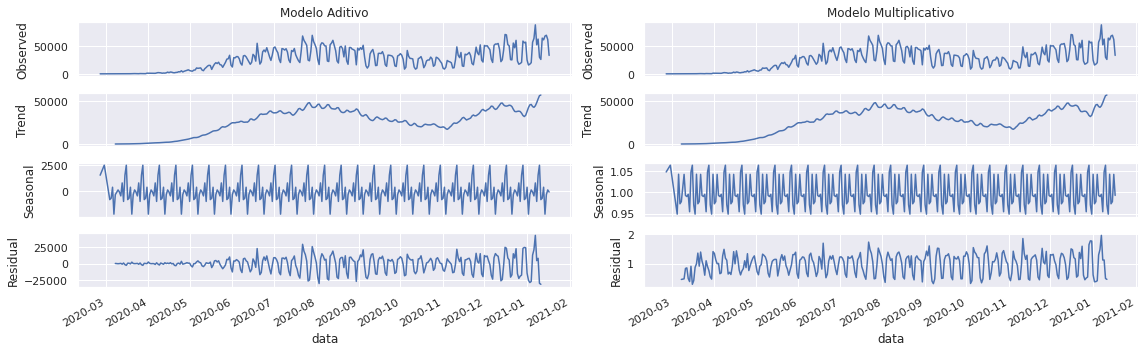

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_add = seasonal_decompose(br_casos_covid["casosNovos"],freq=12,model='additive')
decomposicao_mult = seasonal_decompose(br_casos_covid['casosNovos'],freq=12,model='multiplicative')

def plotseasonal(res, axes, title ):
    res.observed.plot(ax=axes[0], legend=False,title=title)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')


fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,5))

plotseasonal(decomposicao_add, axes[:,0],"Modelo Aditivo")
plotseasonal(decomposicao_mult, axes[:,1],"Modelo Multiplicativo")


plt.tight_layout()
plt.show()


Temos abaixo os dois modelos, onde temos a seguinte fórmula aplicada para descobrir o "detrend", que seria a """""destêndencia"""":

* Modelo aditivo (detrend)  = Tendencia aditiva  - Sazonalidade
<br>
<br>
<img src="https://miro.medium.com/max/469/0*01w8PyfiFJN1rQ6S"      align="center">
<br>
<br>
* Modelo Multiplicativa (detrend) = Tendencia aditiva  / Sazonalidade
<br>
<br>
<img src="https://miro.medium.com/max/341/0*Owj9j479l-SAgIM_" align="center">
<br>

ok, mas e dai? isso vai servir pra que afinal?
Primeiramente, esses valores acima ai vão dar uma ajuda a definir se nossos dados trabalham com o modelo de decomposição multiplicativa ou aditiva. Acima, a gente só tem os dois valores representados. Mas como isso realmente se comporta com relação a nossa base de dados original? A ideia é : **ficar o mais próximo possível do lineplot de casos**

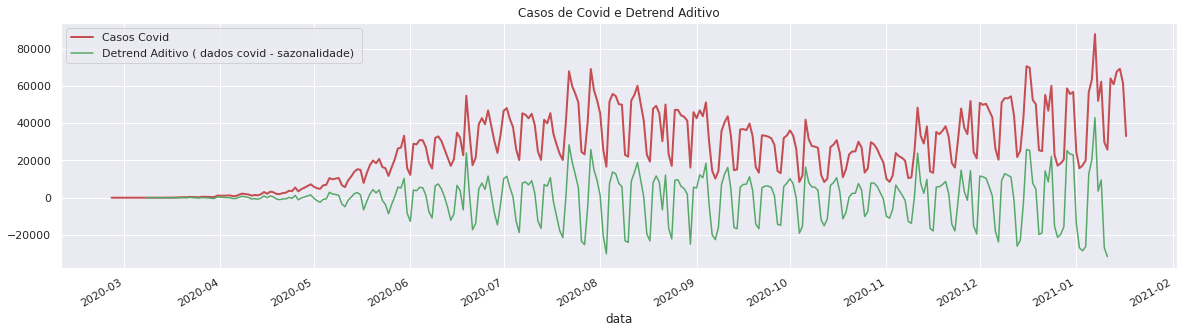

In [26]:
detrend(decomposicao_add,'ADD')

No modelo aditivo, nossos dados não se encaixaram bem em relação aos casos reais. Em compensação, funcionou muito bem com o modelo Multiplicativo. Agora temos certeza que nosso dados são  sazonais multiplicativos

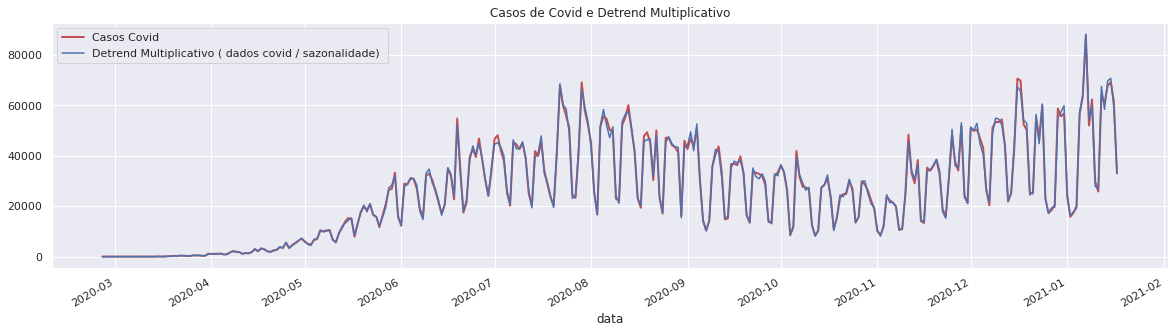

In [27]:
detrend(decomposicao_mult,'mult')

Sabendo que essas coisas, podemos começar a trabalhar mais a fundo com relação ao modelo a usar. Além disso, analisemos com que tipo de série temporal nós temos: estacionária ou não-estacionária. Para descobrir, podemos realizar alguns testes estatísticos como   o teste de Dickley-Fuller, o teste de Phillips-Perron e o teste KPSS.  Mais informações no final do projeto.

###Dados estacionários ou não-estacionários? Vamos testar e descobrir !

A ideia do teste Dickley-Fuller  é um tipo de teste estatístico chamado teste raiz da unidade. A intuição por trás de um teste raiz de unidade é que ele determina o quão fortemente uma série temporal é definida por uma tendência.
Abaixo, iremos verificar se nossa série temporal é ou não, contudo, algumas coisas a se entender antes:

* **Hipótese nula (H0)**: se não rejeitada, sugere que nossa série temporal tem uma raiz de unidade e é não-estacionária, ou seja, tem alguma estrutura dependente de tempo.
* **Hipótese Alternativa (H1)**: A hipótese nula é rejeita, o que sugere que tempos uma estrutura estacionária, que não depende do tempo.


Interpretamos este resultado usando o valor p do teste. Um valor p abaixo de um limiar (como 5% ou 1%) sugere que rejeitemos a hipótese nula (estacionária), caso contrário um valor p acima do limiar sugere que não rejeitamos a hipótese nula (não estacionária).
* **p-valor > 0,05**: Não-estacionário e com raiz de unidade
* **p-valor <= 0,05**: estacionário e sem raiz de unidade.

>A estatística ADF, usada no teste, é um número negativo, e quanto mais negativo, mais indicativo o teste se torna de rejeitar a hipótese nula de que existe raiz unitária na série. O nome do teste faz referência aos estatísticos D. A. Dickey e W. A. Fuller.


In [28]:
from statsmodels.tsa.stattools  import adfuller

test_adfuller = adfuller(br_casos_covid["casosNovos"].values)

print(f"estatística ADF: {test_adfuller[0]}")
print(f"p-value: {test_adfuller[1]}")
print(f"Valores Críticos: ")
for i,j in test_adfuller[4].items():
  print(f"\t{i} : {j}")

if test_adfuller[1] > 0.05:
  print("\nP-value resultado : Dados Não estacionários")
else:
  print("\nP-value resultado: Dados estacionários")  

estatística ADF: -1.0385698226619953
p-value: 0.7389382904849658
Valores Críticos: 
	1% : -3.4521175397304784
	5% : -2.8711265007266666
	10% : -2.571877823851692

P-value resultado : Dados Não estacionários


Vamos tentar também com o **teste de KPSS**. Ele é outro teste para verificar a estacionaridade de uma série temporal. Aqui, a hipótese nula e alternativa para o teste KPSS é oposta do teste Dickey-Fuller (ADF).
* Hipótese Nula: O processso é de tendência estacionária;
* Hipótese Alternativa: A série tem uma raiz unitária (série não estacionária);

Para este teste, não queremos rejeitar a hipótese nula. Em outras palavras, queremos que o p-value seja maior que 0,05 não inferior a 0,05.

In [29]:
from statsmodels.tsa.stattools import kpss

test_kpss = kpss(br_casos_covid["casosNovos"].values,lags="auto")

print(f"Teste Estatítico: {test_kpss[0]}\
        \np-value:{test_kpss[1]}\
        \nLags Used: {test_kpss[2]}")
for i,j in test_kpss[3].items():
  print(f"\t{i}: {j}")
  
if test_kpss[1] > 0.05:
 print("\nP-value resultado : Dados  estacionários\n")
else:
  print("\nP-value resultado: Dados Não estacionários\n")  

Teste Estatítico: 1.6671437140750698        
p-value:0.01        
Lags Used: 10
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

P-value resultado: Dados Não estacionários



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Nossos dados **não são estacionários**  e o que isso impacta em nossa predição? **Bastante**.  Conforme você pode ler no artigo sobre Implementação de um Modelo de Previsão de Demanda em uma Empresa de Varejo (Link nas referências), temos que :

>[...]Uma importante classe de modelos estocásticos utilizados na
representação de séries temporais são os modelos estacionários, que pressupõem um processo
sob equilíbrio, onde a família de variáveis se mantém a um nível constante médio.
Muitas séries temporais são melhores representadas por modelos não-estacionários.
Séries estacionárias variam de maneira estável no tempo, sobre um valor de média fixo.
Entretanto, uma série temporal não-estacionária não se desloca no tempo sobre uma média
fixa. [...]

Além disso, dados não-estacionários, via de regra são imprevisíveis e não são os melhores para serem modelados ou previstos. Contudo, no nosso caso, tentar converter estes dados para uma série temporal estacionária pode não só ser um processo sem resultado satisfatório, como também, pode nos levar a inconclusões referentes a, por exemplo, se o número de casos vai subir ou não. Então, fica a observação aí, a depender do caso, você converte para estacionário ( o que no nosso caso, não parece ser muito bom de se fazer) ou tenta trabalhar com eles em formato não-estacionário, mas tendo a consciência de que talvez os valores de previsão finais possam ser influenciados. Ter um especialista ao lado durante o desenvolvimento de um projeto desse tipo, pode acelerar o trabalho e principalmente, ajudar na precisão do modelo.

Por curiosidade, irei abaixo, mostrar uma forma de converter os dados de não-estacionários para estacionários.

#### Exemplo: **Realizando a transformação para dados estacionários**

Vamos tentar aplicar o método de Detreding por Diferença. Uma nova coluna é construída onde o valor na etapa atual é calculado como a diferença entre a observação original e a observação na etapa anterior. Exemplo:

```
difference(t) = observation(t) - observation(t-1)
```

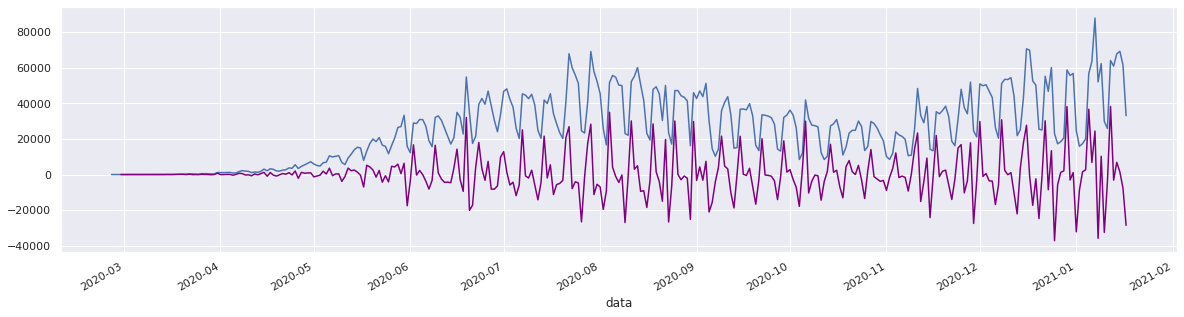

In [30]:
br_casos_covid["casosNovos_diff"] = br_casos_covid["casosNovos"] - br_casos_covid["casosNovos"].shift(1)


br_casos_covid["casosNovos"].plot()
br_casos_covid["casosNovos_diff"].dropna().plot(figsize=(20,5),color='purple')

# br_casos_covid["casosNovos_diff"].cumsum().plot(figsize=(20,5),color='r') # converter de volta para os valores originais

interessante né? Mais informações nos links abaixo.

##tentando  prever com o ARIMA

Vamos finalmente buscar prever os nossos dados com o uso do Modelo Arima. O modelo Arima ou  Auto-Regressive Integrated Moving Average Model ( Modelo autorregressivos integrados e de médias móveis), são modelos estatísticos  que junta o modelo Autorregressivo (AU - de ordem **p**), integrado e médias móveis (MA - de ordem **q**). Nele, os termos autorregressivos correspondem a defasagens da série e as médias móvies são as defasagens dos erros aleatórios.

segundo o artigo de Jorge Manuel Nunes Xavier - *Análise e Previsão de Séries Temporais com Modelos ARIMA e análise espectral singular* : 

>Os modelos ARIMA (p , d, q) são em teoria, a classe mais geral de modelos para a previsão de uma série temporal que não sendo estacionarias podem ser estacionadas por diferenciações.
Os modelos ARIMA são uma generalização dos modelos ARMA que visam basicamente tornar o processo estacionário através de operações diferenças.
Os atrasos da série diferenciada que aparecem na equação de previsão são chamados de termos "auto-regressivos "

###Descobrindo nossos valores p, d, q - Mas o que é isso?

Vamos lá. O arima possui alguns parâmetros necessários pra funcionar. Acontece que estes valores, **p,d,q**  são proevinientes de alguns  outros modelos, o AR (explicado acima) para e o MA. Simplificando, temos:

 * **p**:é o número de termos auto-regressivos;
 * **d**: é o número de diferenciações para que a série se torne estacionária;
 * **q**: é o número termos de médias móveis.

Os termos p, d e q são todos inteiros maiores ou iguais a zero.

Para identificar os modelos **ARIMA** é efetuado  o uso de duas funções:

* Função de Autocorrelação (F.A.C)
>com ela, podemos encontrar um padrão que identifique com algum modelo em particular. É a melhor para encontrar para identificar modelos  MA(q)

* Função de Autocorrelação Parcial (F.A.C.P)
> Ótima para identificar modelos AR puros ou da parte AR de um processo ARMA(p,q). Não muito útil para identificar modelos MA e ARMA.


<img src="https://i.stack.imgur.com/ZZNLG.png">



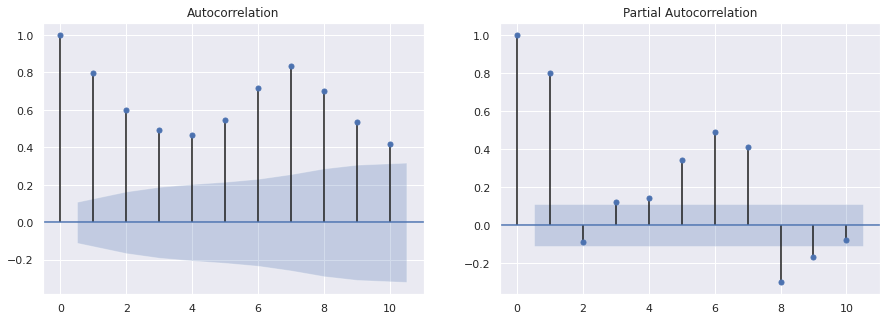

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(br_casos_covid["casosNovos"],lags=10, ax=ax[0]);
plot_pacf(br_casos_covid["casosNovos"],lags=10, ax=ax[1]);

#### Estimando os valores, buscando padrões -  em busca de um milagre.

Terminado o processo de identificação da ordem do modelo ARIMA, o próximo passo é estimar parâmetros desse modelo. Pode-se fazer isso por meio do método dos momentos, estimadores de mínimos quadrados ou estimadores de máxima verossimilhança. Outra coisa importante é realizar o critério correto para escolha de modelos, na medida do possível. Existe o critério de Informação de Akaike (AIC) e a informação Bayesiano (BIC), além do Critério Informações Hannam-Quinn (HQC).  Por estar além dos meus conhecimentos atuais, irei me limitar a já trabalhar com os meus valores (p,d,q).

importamos  o modelo **ARIMA**. Vamos tentar prever então o que vai acontecer no mês de outubro. O que acontece é que, para realizar uma previsão, vamos ter que dividir nosso dataframe em 2:

* dataframe com valores para treino;
* dataframe com valores para teste;

Temos os valores para o mês de outubro, mas, para que possamos treinar o nosso modelo e saber se realmente estamos tendo algum acerto, vamos dividir ele em um outro dataframe de  testes. Abaixo você vai ver melhor isso e fica mais fácil o entendimento.

* Casos Treino = meses menores que o mês 9 (setembro de 2020);
* Casos Teste  = mes igual a outubro (10 de 2020); 

In [32]:
casos_treino = br_casos_covid.query("mes <= 9 and ano == 2020")
casos_teste = br_casos_covid.query("mes == 10  and  ano == 2020" )

aplicamos o **ARIMA**, função responsável que aplicará todos os cálculos avançados. Passamos os casos de treino e colocando a ordem (valores p,d,q) com os valores (12,0,6). Depois passarmos a função, fica apenas nos faltando treinar estes valores, que é o que vamos fazer.

In [41]:
 casos_teste['casos_previsao_arima'] = arima_model(casos_treino['casosNovos'],(12,0,6),31)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


O que temos até o momento :

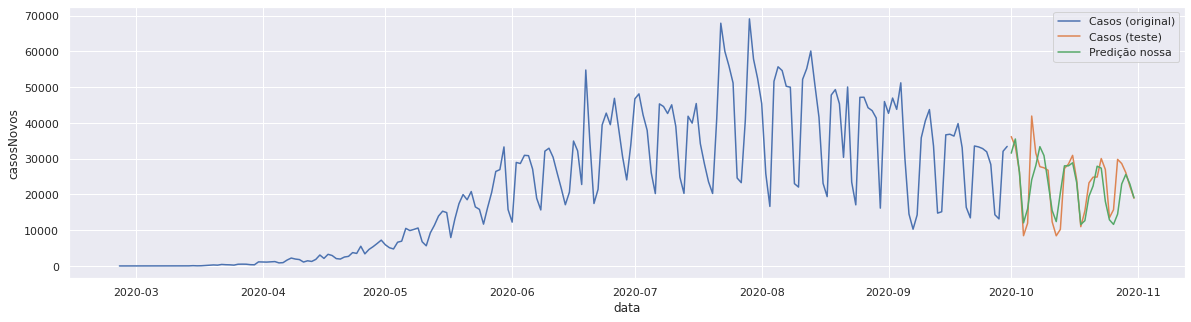

In [42]:
plt.figure(figsize=(20,5))

sns.lineplot(x=casos_treino.index,y="casosNovos",data = casos_treino)
sns.lineplot(x=casos_teste.index,y="casosNovos",data = casos_teste)
sns.lineplot(x=casos_teste.index,y='casos_previsao_arima',data=casos_teste)
plt.legend(['Casos (original)','Casos (teste)','Predição nossa'])
plt.show()

Não ficamos 100% precisos na nossa predição (o que faz parte). O motivo disso varia, contudo, temos algumas pistas para o porquê disso:
 
* Os casos de covid-19 obviamente variam por questões socias. Se a gente pega apenas o comportamento dos casos em azul (casos originalmente), imaginamos que talvez, pela queda que tá tendo até o inicio de outubro, que os casos diminuiriam e formassem uma espécie de "final de onda". Mas como bem sabemos, não foi que aconteceu. Tivemos uma queda em outubro? sim, tivemos, mas ainda assim, as oscilações foram grandes, pois, vendo que os casos estão caindo, as medidas restritivas relaxaram, as pessoas começaram a sair mais e consequentemente se infectar mais rapidamente;

* Nosso calibramento pode não ter sido bem feito. Talvez, tenhamos passados os valores errados (acontece né :^/ );

* O modelos ARIMA pode não ser o melhor, afinal, temos no mínimo uns 10 modelos de previsão. Podemos testar com outros.


Mas antes de partir para outro modelo ou técnica, vamos verificar as métricas da nossa previsão. A ideia aqui é saber a nossa  **pontuação**, nossa precisão de acerto quanto aos dados de teste. Existem várias métricas para analizar nossa previsão. A que usaremos aqui será a **mean squared erro** ou **erro do quadrado médio**:

>Para  trabalhar com o erro quadrado médio, o estatístico deve trabalhar com a soma de todos os resultados tidos como "erros" em relação à previsão inicial e, posteriormente, dividi-los pela quantidade de valores somados. Ou seja, apurar o quanto alguns resultados passam a se afastar de uma média aguardada inicialmente.

Ele retorna um valor do qual, quanto menor, melhor. Vamos ver o que será que ele para nós.

In [67]:
arima = erro_quadrado_medio(casos_teste["casosNovos"],casos_teste['casos_previsao_arima'],'arima')
arima

'RESULTADOS ARIMA = 5633.314850304081'

Nossa pontuação foi bem alta. Mas vamos tentar com outro modelo.

##Tentando prever com o SARIMA

O método Da Média Móvel Integrada Integrada (SARIMA) sazonal modela o próximo passo na sequência como função linear das observações, erros, observações sazonais diferentes e erros sazonais em etapas anteriores.

Combina o modelo ARIMA com a capacidade de realizar a mesma autoregressão, diferenciamento e modelagem média móvel no nível sazonal.

In [47]:
casos_teste['casos_previsao_samira'] = model_sarima(casos_treino['casosNovos'],(12,0,6),(12,0,6,8),31)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarni

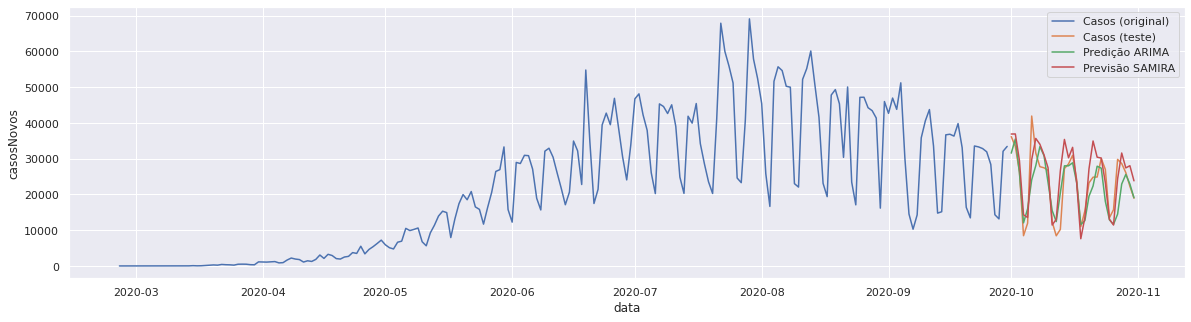

In [48]:
plt.figure(figsize=(20,5))

sns.lineplot(x=casos_treino.index,y="casosNovos",data = casos_treino)
sns.lineplot(x=casos_teste.index,y="casosNovos",data = casos_teste)
sns.lineplot(x=casos_teste.index,y='casos_previsao_arima',data=casos_teste)
sns.lineplot(x=casos_teste.index,y='casos_previsao_samira',data=casos_teste)
plt.legend(['Casos (original)','Casos (teste)','Predição ARIMA', 'Previsão SAMIRA'])
plt.show()

In [66]:
sarima = erro_quadrado_medio(casos_teste['casosNovos'],casos_teste['casos_previsao_samira'],"SARIMA")
sarima

'RESULTADOS SARIMA = 5485.154576569957'

Temos agora com o modelo SARIMA uma pontuação menor. Olhando mais de perto, ficamos assim:

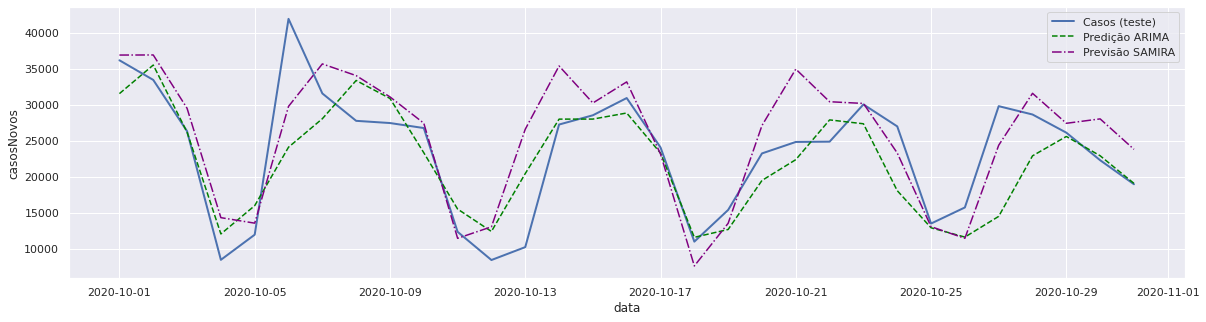

In [65]:
plt.figure(figsize=(20,5))
sns.lineplot(x=casos_teste.index,y="casosNovos",data = casos_teste,linewidth= 2)
sns.lineplot(x=casos_teste.index,y='casos_previsao_arima',data=casos_teste,color='green',linestyle='--')
sns.lineplot(x=casos_teste.index,y='casos_previsao_samira',data=casos_teste,color='purple',linestyle='-.')
plt.legend(['Casos (teste)','Predição ARIMA', 'Previsão SAMIRA'])
plt.show()


##E o que podemos concluir até agora?

Temos os seguintes resultados usando os modelos **ARIMA** e **SARIMA**

In [68]:
print(f"{arima}\n{sarima}")

RESULTADOS ARIMA = 5633.314850304081
RESULTADOS SARIMA = 5485.154576569957


Nossas métricas informam que o modelo SARIMA ( que trabalha com sazonalidade), obteve um resultado mais satisfatório, apesar de ainda ser alto. Mas o que pode estar influenciando nisso? como dito lá pra cima, o comportamento da população reflete diretamente no número de casos. As pessoas até o mês 9, possuiam um comportamento X, indicando uma queda, contudo, como bem sabemos, o relaxamento influenciou no descomprimento das medidas restritivas, fazendo com que as pessoas voltassem a sair. Não prevemos um acerto de 100% mas se você analisar bem, os dois gráficos mostram as subidas e descidas no mesmo ritmo dos dados originais. Conseguimos seguir esse comportamento !

#Prevendo óbitos Novos - Brasil

In [70]:
br_mortes_covid = dados_brasil[["data","casosNovos","obitosNovos",]].copy()
br_mortes_covid.set_index("data",inplace=True)
br_mortes_covid = br_mortes_covid.query("obitosNovos > 0")

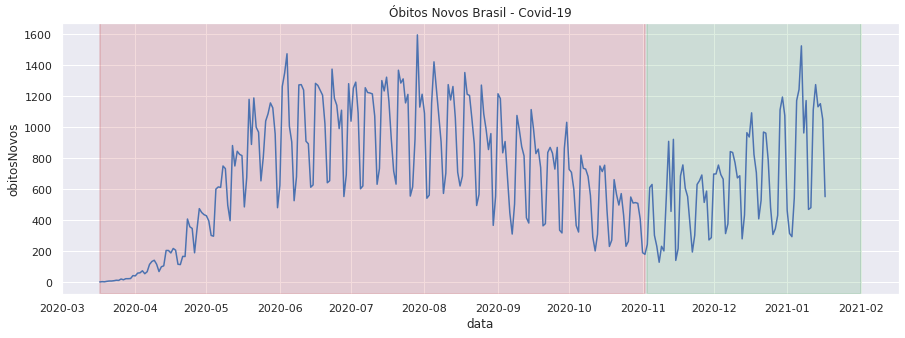

In [71]:
plot_br(br_mortes_covid,"obitosNovos",'Óbitos Novos Brasil - Covid-19')

plt.axvspan(np.datetime64('2020-03-17'),np.datetime64('2020-11-02') ,color='r',linewidth=2,alpha=0.2)
plt.axvspan(np.datetime64('2020-11-03'),np.datetime64('2021-02-01') ,color='g',linewidth=2,alpha=0.2)

#Referências


* [Minhas série temporal é aditiva ou Multiplicativa?](https://www.r-bloggers.com/2017/02/is-my-time-series-additive-or-multiplicative/)

* [Seasonal decomposition forescasting](https://new.censusatschool.org.nz/resource/seasonal-decomposition-forecasting/)

* [Additive and multiplicative seasonality – can you identify them correctly?](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/)

* [A Visual Guide to Time Series Decomposition Analysis](https://medium.com/better-programming/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930)

* [ Correlação, Autocorrelação e Autocorrelação Parcial - por Frank Magalhães de Pinho - IBMEC/MG ](https://www.rpubs.com/frank-pinho/522360#:~:text=A%20s%C3%A9rie%20temporal%20dos%20retornos,informa%C3%A7%C3%B5es%20dispon%C3%ADveis%20antes%20de%20t.)

* [Estacionariedade](http://www.portalaction.com.br/series-temporais/11-estacionariedade#:~:text=Uma%20s%C3%A9rie%20temporal%20%C3%A9%20dita,estacionariedade%2C%20por%20exemplo%2C%20tend%C3%AAncia.)

* [TESTES DE ESTACIONARIEDADE](http://www.portalaction.com.br/series-temporais/11-estacionariedade#:~:text=Uma%20s%C3%A9rie%20temporal%20%C3%A9%20dita,estacionariedade%2C%20por%20exemplo%2C%20tend%C3%AAncia.)

* [Implementação de um Modelo de Previsão de Demanda em uma Empresa de Varejo da
Serra Gaúcha](http://www.ucs.br/etc/conferencias/index.php/mostraucsppga/xviimostrappga/paper/viewFile/5228/1834)


* [Stationarity and detrending (ADF/KPSS)](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

* [Como funciona o teste de KPSS](https://nwfsc-timeseries.github.io/atsa-labs/sec-boxjenkins-kpss.html)

* [Basic stochastic Models](https://bookdown.org/rushad_16/TSA_Lectures_book/basic-stochastic-models.html#non-stationary-models)
